## Module import
Loading necessary modules for the script to execute

In [4]:
import torch
import math
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import copy
from sklearn.metrics import r2_score
import blosum

In [5]:
print(torch.get_num_interop_threads())
print(torch.get_num_threads())

6
6


## Data pre-processing
Here we load the csv file. The labels are the BA values log-tranformed. Then peptides are encoded by a vector of size 20.

In [6]:
ba_threshold = 500e3
csv_path = "../binding_data/BA_pMHCI.csv"
csv_peptides = []
csv_ba_values = []
with open(csv_path) as csv_f:
    rows = [row.replace("\n", "").split(",") for row in csv_f]
    for row in rows:
        if float(row[3]) <= ba_threshold:
            csv_peptides.append(row[2])
            csv_ba_values.append(float(row[3]))

# onehot encoding:
aminoacids = ('ACDEFGHIKLMNPQRSTVWY')
def peptide2onehot(peptide):
    AA_eye = torch.eye(20, dtype=torch.float)
    return torch.stack([AA_eye[aminoacids.index(res)] for res in peptide])

# make the blosum encoding:
def peptide2blosum(peptide):
    mat = blosum.BLOSUM(62)
    blosum_t = [[]]
    blosum_aa = ["A"]
    for aa in mat.keys():
        if aa[0] in aminoacids and aa[1] in aminoacids:
            if len(blosum_t[-1]) < 20:
                blosum_t[-1].append(mat[aa]) 
            else:
                blosum_aa.append(aa[0])
                blosum_t.append([mat[aa]])
    blosum_t = torch.tensor(blosum_t)
    blosum_aa = "".join(blosum_aa)
    return torch.stack([blosum_t[blosum_aa.index(res)] for res in peptide])

def peptide2blosum_sparse(peptide):
    AA_eye = torch.eye(20, dtype=torch.float)
    mat = blosum.BLOSUM(62)
    blosum_t = [[]]
    blosum_aa = ["A"]
    for aa in mat.keys():
        if aa[0] in aminoacids and aa[1] in aminoacids:
            if len(blosum_t[-1]) < 20:
                blosum_t[-1].append(mat[aa]) 
            else:
                blosum_aa.append(aa[0])
                blosum_t.append([mat[aa]])
    blosum_t = torch.tensor(blosum_t)
    blosum_aa = "".join(blosum_aa)
    return [blosum_t[blosum_aa.index(res)].tolist() + AA_eye[aminoacids.index(res)].tolist() for res in peptide]
peptides = torch.tensor([peptide2blosum_sparse(p) for p in csv_peptides])
# peptides = [peptide2blosum(p) for p in csv_peptides]

## Separate train, validation and test dataset
The train dataset is used for the training of the model. Validation dataset allows to evaluate the performance of the model at a given epoch on a different dataset than the one used for learning. The test dataset assesses the accuracy of model's prediction.
Before spliting the initial dataset into several components, data is shuffled and splitted without redundancies.

The binding affinity values are normalized around 0 and 1 using normalization and sigmoid function. For the normalization, training set's mean and standard deviation are used for the validation and test datasets so the binding affinity values are always in the training distribution.

tensor([4.1000e+01, 5.0170e+03, 4.0000e+02,  ..., 2.0000e+00, 1.1228e+03,
        1.2970e+02], dtype=torch.float64)
tensor([4.1000e+01, 5.0170e+03, 4.0000e+02,  ..., 2.0000e+00, 1.1228e+03,
        1.2970e+02], dtype=torch.float64)


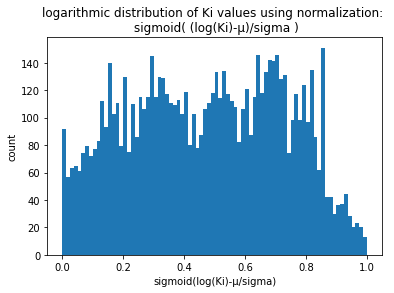

In [7]:
# dataset proportions
train_p = 0.7
validation_p = 0.2
test_p = 0.1

# hyperparameters
neurons_per_layer = 1000
batch = 64
epochs = 150

# other parameters:
device = ("cpu", "cuda")[torch.cuda.is_available()]

# make the dataset class:
class Peptides(Dataset):
    def __init__(self):
        self.ba_values = torch.tensor(csv_ba_values, dtype=torch.float64)
        self.peptides = peptides
    def __getitem__(self,idx):
        return self.peptides[idx],self.ba_values[idx]
    def __len__(self):
        return len(self.peptides)

#create datasets:
dataset_length = len(peptides)
dataset_splits = torch.round(torch.tensor([train_p*dataset_length, validation_p*dataset_length, test_p*dataset_length])).int()
dataset = Peptides()
train,validation,test = random_split(dataset,dataset_splits)

# calculate the min,max and std values:
training_mean = torch.log(dataset.ba_values[train.indices]).mean()
training_min = torch.log(dataset.ba_values[train.indices]).min()
training_max = torch.log(dataset.ba_values[train.indices]).max()

# define normalize to transform data and renormalize
def normalize(ds):
    ds = torch.log(ds)
    return (ds - training_min)/(training_max-training_min)
def renorm(ds):
    ds = ds*(training_max - training_min)+training_min
    return torch.exp(ds)

# normalize binding affinity distribution around 0 and 1 using normalization and sigmoid
print(dataset.ba_values)
dataset.ba_values = normalize(dataset.ba_values)
print(renorm(dataset.ba_values))

# train datasets vizualisation
ba_values = dataset.ba_values.tolist()
plt.hist(ba_values, bins=80)
plt.title("logarithmic distribution of Ki values using normalization: \n sigmoid( (log(Ki)-µ)/sigma )")
plt.xlabel("sigmoid(log(Ki)-µ/sigma)")
plt.ylabel("count")
plt.show()

# visualize data
print(dataset.peptides)

# # create the dataloaders iterators:
train_dataloader = DataLoader(train, batch_size=batch)
validation_dataloader = DataLoader(validation, batch_size=batch)
test_dataloader = DataLoader(test, batch_size=batch)

## Training the model
First, we define the neural network architecture of the multi layer perceptron (MLP). The MLP is made of 2 layers and `neurons_per_layer` number of neurons per layer. The loss function used is cross entropy, which measures the difference of entropy between an expected probability distribution and the model's. The optimizer is ADAM.

The train function allows to train the model for `e` number of `epoches`.

In [8]:
class MLP(nn.Module):
    def __init__(self, outputs=2):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(40*9, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, outputs),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

model = MLP(outputs=1).to(device)

# define the loss function and the optimizer:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

# define the train function
def train(dataloader, model, loss_fn,optimizer):
    model.train()
    for X,y in dataloader:
        # forward propagation
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,torch.reshape(y,(-1,1)).float())

        # backpropagation
        optimizer.zero_grad() # old gradient removed (Adam optimizer uses momentum but it is handled internally)
        loss.backward() # calculates the gradient by making derivatives 
        optimizer.step() # performs a single parameters update using the calculated gradient

#define the validation function
def evaluate(dataloader, model):
    model.eval()
    with torch.no_grad():
        y_vals = torch.tensor([])
        pred_vals = torch.tensor([])
        for X,y in dataloader:
            pred = model(X)
            y_vals = torch.cat((y_vals, y), 0)
            pred_vals = torch.cat((pred_vals, pred),0)
    return y_vals,pred_vals

Now we train the model. At the end of each epoches we plot the PPV (positively predicted values) rate both for the training dataset and the validation dataset thus assessing the predictive and generalizing performances of the model.

In [9]:
train_losses = []
validation_losses = []
best_model = {
    "validation_rate": 100,
    "model": None,
    "epoch": None,
}
for e in range(epochs):
    # calculate train loss:
    train_y_ba, train_pred_ba = evaluate(train_dataloader, model)
    # train_loss = torch.absolute(renorm(train_y_ba) - renorm(train_pred_ba))
    train_loss = torch.absolute(train_y_ba - torch.reshape(train_pred_ba, (-1,)))
    train_loss_mean = train_loss.mean()
    train_losses.append(train_loss_mean)

    #calculate validation loss:
    validation_y_ba,validation_pred_ba = evaluate(validation_dataloader, model)
    # validation_loss = torch.absolute(renorm(validation_pred_ba) - renorm(validation_y_ba))
    validation_loss = torch.absolute(validation_y_ba - torch.reshape(validation_pred_ba, (-1,)))
    validation_loss_mean = validation_loss.mean()
    validation_losses.append(validation_loss_mean)
    if (validation_loss_mean < best_model["validation_rate"]):
        best_model["model"] = copy.deepcopy(model)
        best_model["validation_rate"] = validation_loss_mean
        best_model["epoch"] = e
    train(train_dataloader, model, loss_fn, optimizer) #train on the whole database in batches

## Plot the results

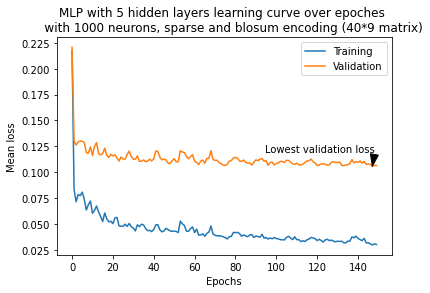

/tmp/ipykernel_12198/598423861.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,ba_threshold])
/tmp/ipykernel_12198/598423861.py:64: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,ba_threshold])


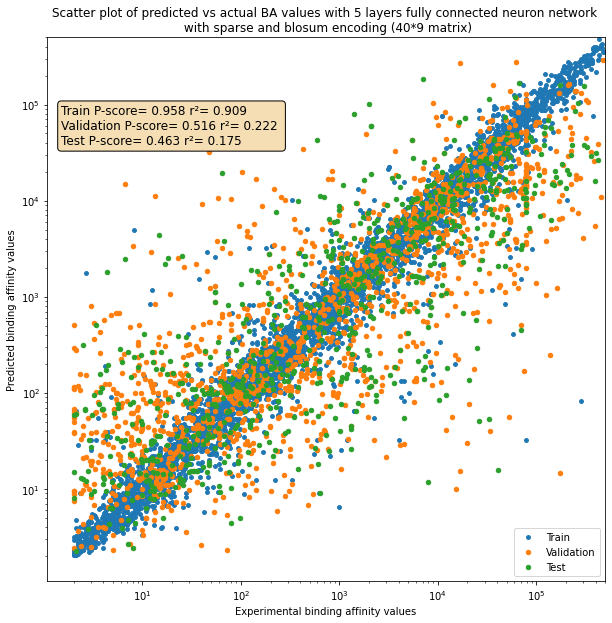

In [10]:
#plot the training and validation loss
plt.plot(range(epochs), train_losses, label="Training")
plt.plot(range(epochs), validation_losses, label="Validation")
plt.legend(["Training", "Validation"])
plt.title("MLP with 5 hidden layers learning curve over epoches \n \
    with 1000 neurons, sparse and blosum encoding (40*9 matrix)")
plt.xlabel("Epochs")
plt.ylabel("Mean loss")
plt.annotate("Lowest validation loss",
    xy=(best_model["epoch"], best_model["validation_rate"]),
    xycoords='data',
    xytext=(best_model["epoch"]+1, best_model["validation_rate"]+best_model["validation_rate"]/5),
    arrowprops=dict(facecolor="black", shrink=0.01, width=1, headwidth=8),
    horizontalalignment="right", verticalalignment="top"
)
plt.show()

# use the best model for evaluation
# evaluate_model = best_model["model"]
evaluate_model = model

# retrieve the predicted and actual values
train_y_ba, train_pred_ba = evaluate(train_dataloader, evaluate_model)
validation_y_ba, validation_pred_ba = evaluate(validation_dataloader, evaluate_model)
test_y_ba,test_pred_ba = evaluate(test_dataloader, evaluate_model)

# renormalize the values
train_y_ba = renorm(train_y_ba)
train_pred_ba = renorm(train_pred_ba)

validation_y_ba = renorm(validation_y_ba)
validation_pred_ba = renorm(validation_pred_ba)

test_y_ba = renorm(test_y_ba)
test_pred_ba = renorm(test_pred_ba)

# look at the pearson correlation score:
train_corr, _ = pearsonr(train_y_ba, train_pred_ba)
validation_corr, _ = pearsonr(validation_y_ba, validation_pred_ba)
test_corr, _ = pearsonr(test_y_ba, test_pred_ba)

train_r = r2_score(train_y_ba, train_pred_ba)
validation_r = r2_score(validation_y_ba, validation_pred_ba)
test_r = r2_score(test_y_ba, test_pred_ba)

# plot the values
s = 1
plot_txt = f"Train P-score= {train_corr[0]:.3f} r²= {train_r:.3f} \n\
Validation P-score= {validation_corr[0]:.3f} r²= {validation_r:.3f} \n\
Test P-score= {test_corr[0]:.3f} r²= {test_r:.3f}"
plt.figure(figsize=(10,10))
plt.scatter(train_y_ba, train_pred_ba, label="Train", s=15)
plt.scatter(validation_y_ba, validation_pred_ba, label="Validation", s=s*20)
plt.scatter(test_y_ba, test_pred_ba, label="Test", s=s*20)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="lower right")
plt.xlabel("Experimental binding affinity values")
plt.ylabel("Predicted binding affinity values")
plt.title("Scatter plot of predicted vs actual BA values with 5 layers fully connected neuron network \n \
with sparse and blosum encoding (40*9 matrix)")
plt.text(1.5, 1e5, plot_txt, fontsize=12, horizontalalignment="left", verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat"))
plt.xlim([0,ba_threshold])
plt.ylim([0,ba_threshold])
plt.show()


## Model performances
### With half-decreasing number of neurones
- 3 hidden layers
- Initial number of neurons: 1000 then decreasing by half for each layer
- best test-validation delta: 0.065